In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Statistical analysis
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Machine learning (supervised learning)
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

<h1>Load and Simple Analysis<h1>

In [ ]:
df = pd.read_excel("2021.xlsx")
df.head()

In [ ]:
# Check data types and non-null counts
print("Data Summary:")
print(df.info())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

In [ ]:
print("\nUnique Values per Column:")
for column in df.columns:
    print(f"\n{column}:")
    print(f"Unique Count: {df[column].nunique()}")
    print(f"First 10 Unique Values: {df[column].unique()[:10]}")

In [ ]:
# drop rows with missing values
clean_df = df.dropna(subset=['店铺名称', '品牌名称'])
print("\nCleaned Data Summary:")
print(clean_df.info())

In [ ]:
# Create a dictionary to map platform names
platform_mapping = {
    '抖音': 'Douyin',
    '京东': 'JD',
    '天猫': 'Tmall'
}

# Apply the mapping to the '一级平台' column
clean_df['Primary Platform'] = clean_df['一级平台'].map(platform_mapping)

In [ ]:
# Column name mapping dictionary
column_mapping = {
    '销售月份': 'Sales Month',
    '一级平台': 'Primary Platform (Original)',
    '二级平台': 'Secondary Platform',
    '店铺名称': 'Store Name',
    '品牌名称': 'Brand Name',
    '商品编码': 'Product Code',
    '销售金额': 'Sales Amount',
    '销售数量': 'Sales Quantity'
}

# Rename columns
clean_df = clean_df.rename(columns=column_mapping)

In [ ]:
# Split data by platform and save to CSV
platforms = clean_df['Primary Platform'].unique()

for platform in platforms:
    platform_data = clean_df[clean_df['Primary Platform'] == platform]
    platform_data.to_csv(f'{platform}_sales_data.csv', index=False)

<h1>Douyin Analysis</h1>


Missing Values in Douyin Data:
Sales Month                    0
Primary Platform (Original)    0
Secondary Platform             0
Store Name                     0
Brand Name                     0
Product Code                   0
Sales Amount                   0
Sales Quantity                 0
Primary Platform               0
dtype: int64


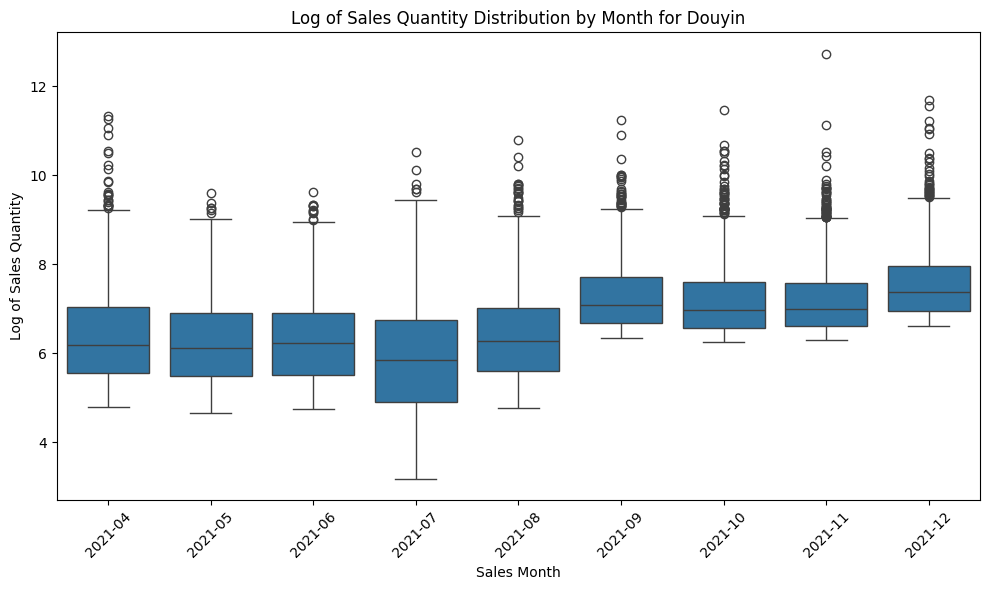

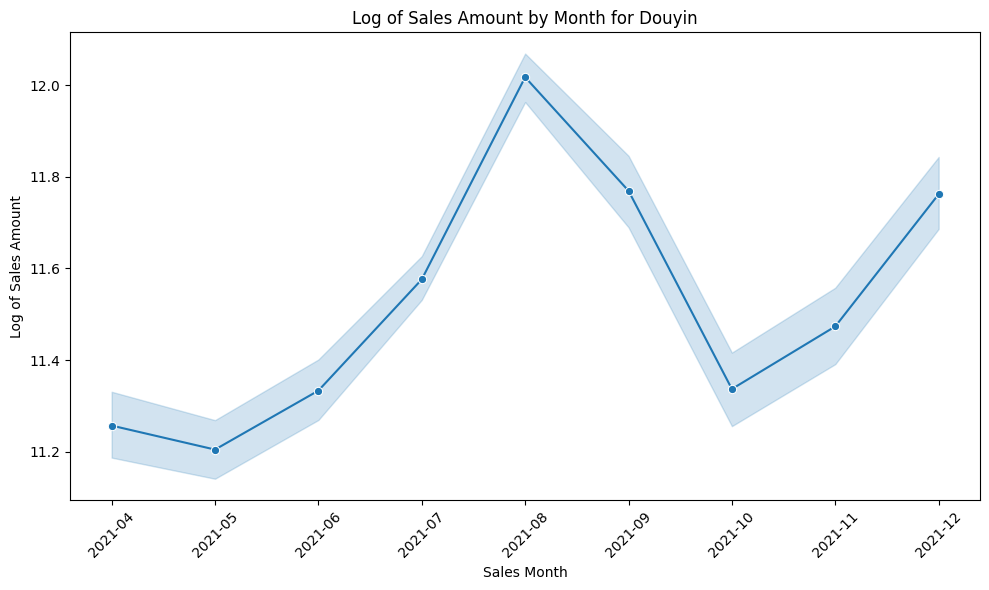

In [2]:
dy_df = pd.read_csv('Douyin_sales_data.csv')
# Check for missing values in Douyin data
print("\nMissing Values in Douyin Data:")
print(dy_df.isnull().sum())
# Visualize log of sales quantity distribution by month for Douyin
plt.figure(figsize=(10, 6))
sns.boxplot(data=dy_df, x='Sales Month', y=np.log1p(dy_df['Sales Quantity']))
plt.title('Log of Sales Quantity Distribution by Month for Douyin')
plt.xlabel('Sales Month')
plt.ylabel('Log of Sales Quantity')
plt.xticks(rotation=45)
plt.tight_layout()
# Visualize log sales amount by month for Douyin
plt.figure(figsize=(10, 6))
sns.lineplot(data=dy_df, x='Sales Month', y=np.log1p(dy_df['Sales Amount']), marker='o')
plt.title('Log of Sales Amount by Month for Douyin')
plt.xlabel('Sales Month')
plt.ylabel('Log of Sales Amount')
plt.xticks(rotation=45)
plt.tight_layout()

In [3]:
def categorize_store(store_name):
    if '官方旗舰店' in store_name:
        return 'Official Flagship'
    elif '卖场旗舰店' in store_name:
        return 'Mall Flagship'
    elif '旗舰店' in store_name:
        return 'Flagship'
    elif '专卖店' in store_name or '专营店' in store_name:
        return 'Specialty Store'
    elif '卖场店' in store_name:
        return 'Mall Store'
    else:
        return 'Other'

# Apply categorization
dy_df['Store Type'] = dy_df['Store Name'].apply(categorize_store)

In [4]:
print(dy_df['Store Type'].value_counts())

Store Type
Specialty Store      9082
Official Flagship    1566
Mall Flagship        1402
Flagship             1053
Mall Store            213
Other                 184
Name: count, dtype: int64


In [5]:
# To capture "官方" (official) distinction separately
dy_df['is_official'] = dy_df['Store Name'].str.contains('官方').astype(int)

In [6]:
# Encode categorical variables (e.g., 'Store Type') - keep all categories
encoder = OneHotEncoder(sparse_output=False, drop=None)  # Changed from drop='first'
store_type_encoded = encoder.fit_transform(dy_df[['Store Type']])
store_type_df = pd.DataFrame(store_type_encoded, columns=encoder.get_feature_names_out(['Store Type']))
dy_df = pd.concat([dy_df, store_type_df], axis=1)

Correlation Matrix:
                 Sales Quantity  is_official
Sales Quantity        1.000000    -0.032684
is_official          -0.032684     1.000000


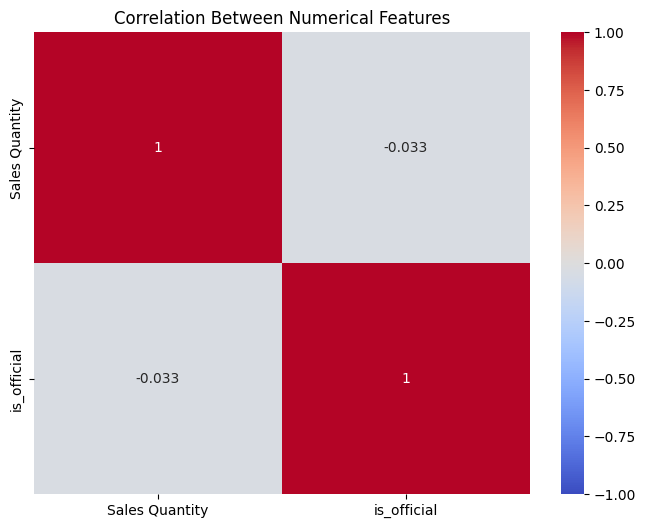

In [7]:
# Calculate Pearson correlation
corr_matrix = dy_df[['Sales Quantity', 'is_official']].corr()
print("Correlation Matrix:\n", corr_matrix)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between Numerical Features')
plt.show()

Mean Squared Error: 13495525.69
R² Score: 0.019
Feature Importances: [0.77627616 0.00743695 0.02165209 0.10360307 0.05365321 0.00995368
 0.01105158 0.01637325]


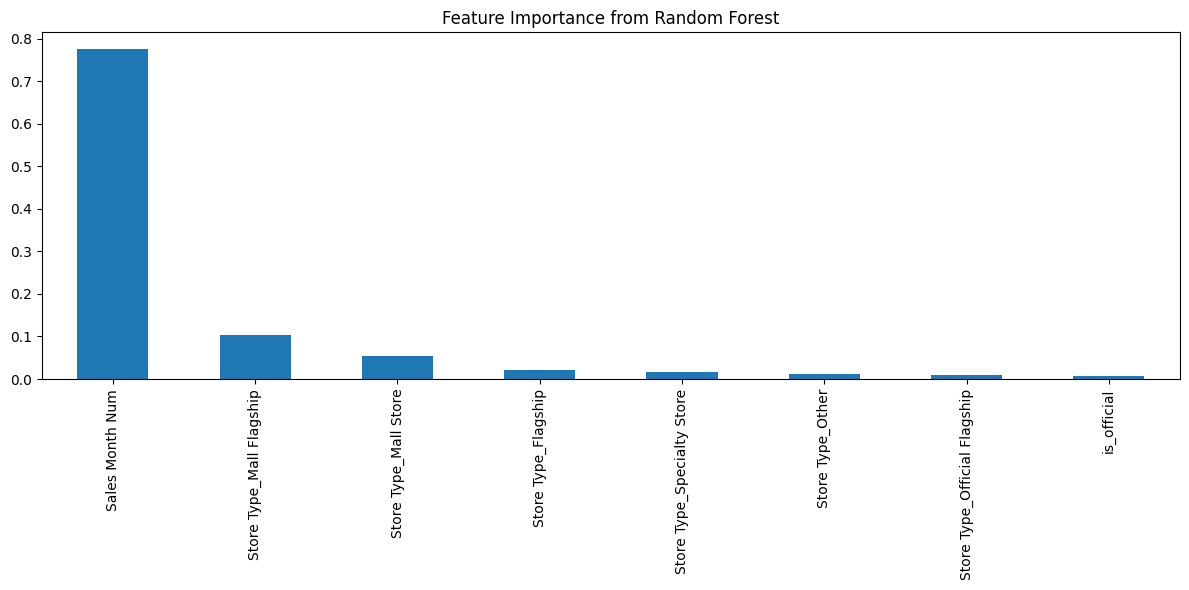

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Prepare features (encode categorical variables)
features = [
    'Sales Month Num',  # Use the numerical version we created
    'is_official',
    'Store Type_Flagship',
    'Store Type_Mall Flagship', 
    'Store Type_Mall Store', 
    'Store Type_Official Flagship', 
    'Store Type_Other', 
    'Store Type_Specialty Store'  # Added missing comma here
    # Note: Removed 'Brand Name' for now since it has many categories and would need encoding
]

# Convert 'Sales Month' to numerical (e.g., month number)
dy_df['Sales Month Num'] = pd.to_datetime(dy_df['Sales Month']).dt.month

# Split data
X = dy_df[features]
y = dy_df['Sales Quantity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions and evaluation
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.3f}")
print(f"Feature Importances: {rf.feature_importances_}")

# Feature importance
importance = pd.Series(rf.feature_importances_, index=X.columns)
importance.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
plt.title('Feature Importance from Random Forest')
plt.tight_layout()
plt.show()

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select numerical features
numerical_features = [
    'Sales Month Num',  # Use the numerical version we created
    'is_official',
    'Store Type_Flagship',
    'Store Type_Mall Flagship', 
    'Store Type_Mall Store', 
    'Store Type_Official Flagship', 
    'Store Type_Other', 
    'Store Type_Specialty Store'  # Added missing comma here
    # Note: Removed 'Brand Name' for now since it has many categories and would need encoding
]
vif_data = dy_df[numerical_features]

vif = pd.DataFrame()
vif["Feature"] = vif_data.columns
vif["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(len(vif_data.columns))]
print("\nVIF Scores:\n", vif)


VIF Scores:
                         Feature          VIF
0               Sales Month Num     1.020557
1                   is_official  1385.539513
2           Store Type_Flagship     1.740610
3      Store Type_Mall Flagship     1.806224
4         Store Type_Mall Store     1.154037
5  Store Type_Official Flagship  1569.669863
6              Store Type_Other     1.172698
7    Store Type_Specialty Store     7.899179


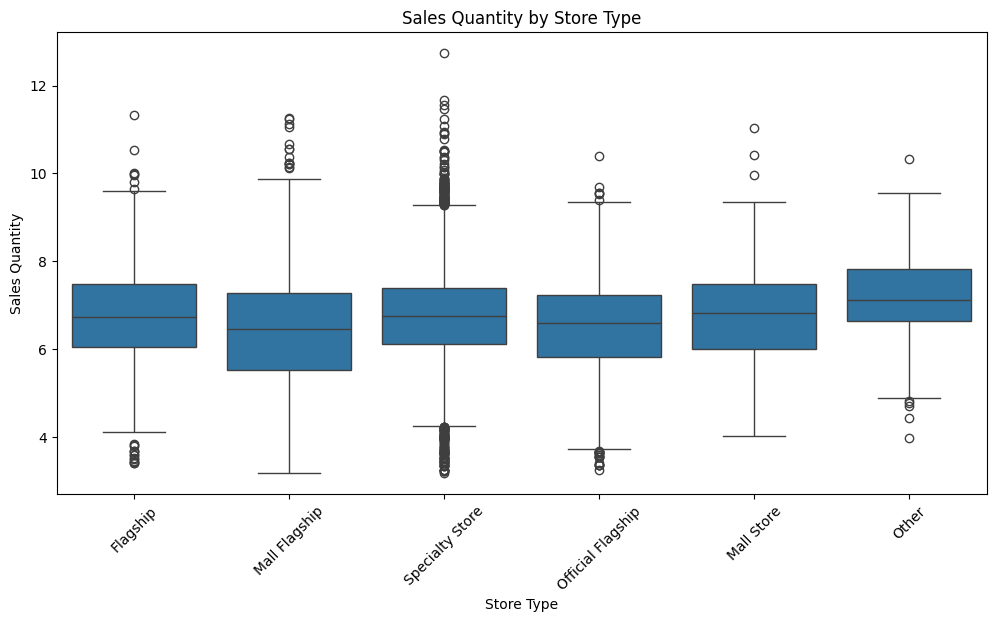

In [10]:
# -- log sales quantity by store type
plt.figure(figsize=(12, 6))
sns.boxplot(x='Store Type', y=np.log1p(dy_df['Sales Quantity']), data=dy_df)
plt.title('Sales Quantity by Store Type')
plt.xticks(rotation=45)
plt.show()

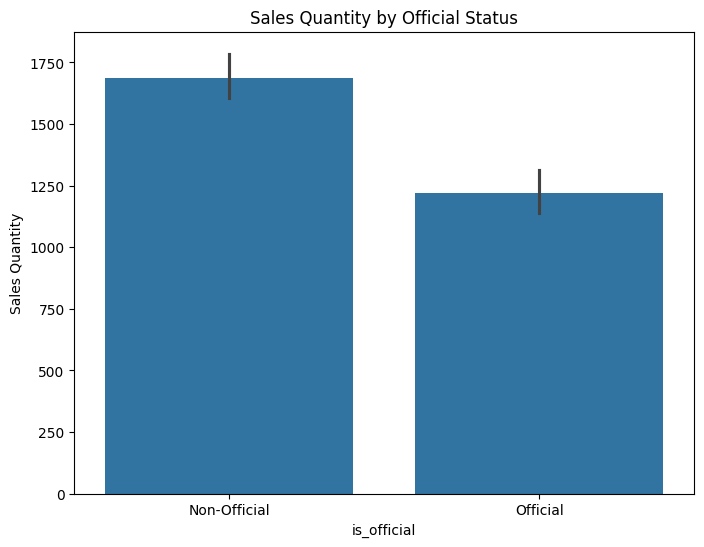

In [11]:
plt.figure(figsize=(8, 6))
sns.barplot(x='is_official', y='Sales Quantity', data=dy_df)
plt.title('Sales Quantity by Official Status')
plt.xticks(ticks=[0, 1], labels=['Non-Official', 'Official'])
plt.show()

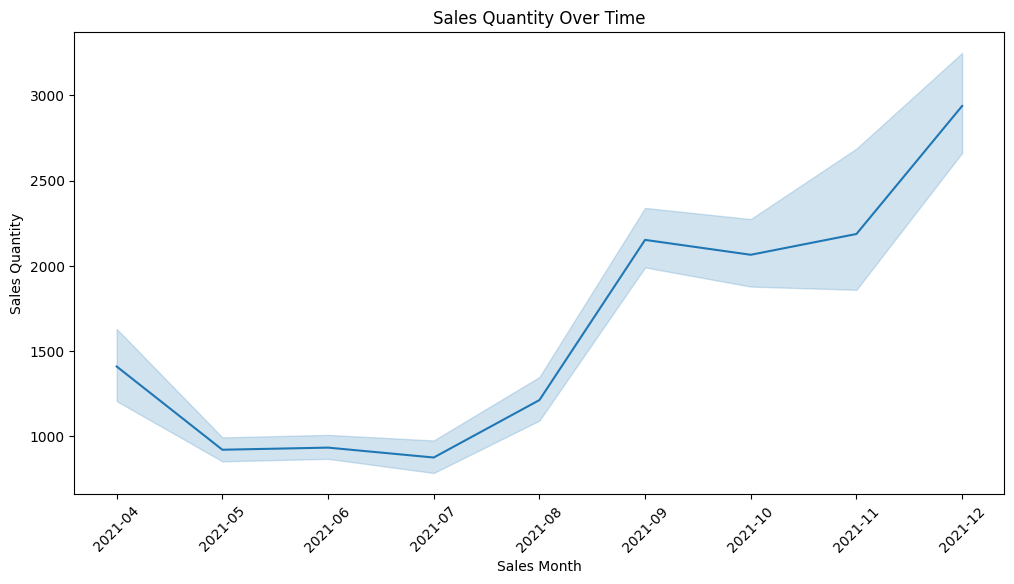

In [12]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Sales Month', y='Sales Quantity', data=dy_df)
plt.title('Sales Quantity Over Time')
plt.xticks(rotation=45)
plt.show()

In [13]:
# ------- Feature Engineering --------- #
# Convert 'Sales Month' to categorical dummies
dy_df = pd.get_dummies(dy_df, columns=['Sales Month'])

In [14]:
from category_encoders import TargetEncoder

# Initialize TargetEncoder
te = TargetEncoder(smoothing=1.0)  # Smoothing to handle rare brands

# Fit and transform
dy_df['Brand Name Encoded'] = te.fit_transform(
    dy_df['Brand Name'], 
    dy_df['Sales Quantity']
)

# Get top brands and create binary indicator
top_brands = dy_df['Brand Name'].value_counts().head(5).index
print("\nTop Brands:")
print(top_brands)

# Create binary indicator for top brands
dy_df['is_top'] = dy_df['Brand Name'].isin(top_brands).astype(int)

# Check the distribution
print(f"\nTop brand distribution:")
print(dy_df['is_top'].value_counts())


Top Brands:
Index(['其他', '五粮液', '茅台', '白水杜康', '汾酒'], dtype='object', name='Brand Name')

Top brand distribution:
is_top
1    9000
0    4500
Name: count, dtype: int64


In [16]:
# Create is_promote column based on promotional periods using Sales Month Num
def is_promotional_period_num(month_num):
    """
    Determine if a sales month (numeric) falls within a promotional period.
    Promotional months: 1, 6, 9, 11, 12
    """
    promotional_months = [1, 6, 9, 11, 12]
    return 1 if month_num in promotional_months else 0

# Apply the function to create is_promote column
dy_df['is_promote'] = dy_df['Sales Month Num'].apply(is_promotional_period_num)

# Check the distribution
print("Promotional period distribution:")
print(dy_df['is_promote'].value_counts())

# Show breakdown by month
print("\nPromotional periods by month:")
promotion_by_month = dy_df.groupby('Sales Month Num')['is_promote'].first().sort_index()
print(promotion_by_month)

Promotional period distribution:
is_promote
0    7500
1    6000
Name: count, dtype: int64

Promotional periods by month:
Sales Month Num
4     0
5     0
6     1
7     0
8     0
9     1
10    0
11    1
12    1
Name: is_promote, dtype: int64


In [17]:
final_features = [
    # Store Type (already one-hot encoded)
    'Store Type_Flagship',
    'Store Type_Mall Flagship', 
    'Store Type_Mall Store', 
    'Store Type_Official Flagship', 
    'Store Type_Other', 
    'Store Type_Specialty Store',
    
    # Brand Features
    'Brand Name Encoded', 
    'is_top',
    
    # Time Features (seasonality)
    'Sales Month_2021-04',
    'Sales Month_2021-05', 
    'Sales Month_2021-06', 
    'Sales Month_2021-07', 
    'Sales Month_2021-08', 
    'Sales Month_2021-09', 
    'Sales Month_2021-10', 
    'Sales Month_2021-11', 
    'Sales Month_2021-12',
    'is_promote'
]

In [18]:
# Drop excluded columns for column names not in final_features and not Sales Quantity
dy_df = dy_df[final_features + ['Sales Quantity']]

In [19]:
dy_df.to_csv('processed_douyin_sales_data.csv', index=False)

<h1>Douyin Sales Quantity Prediction</h1>

In [20]:
# Create a 'Sales Month' column (e.g., '2021-04', '2021-05', etc.)
dy_df['Sales Month'] = dy_df[['Sales Month_2021-04',
                             'Sales Month_2021-05',
                             'Sales Month_2021-06',
                             'Sales Month_2021-07',
                             'Sales Month_2021-08',
                             'Sales Month_2021-09',
                             'Sales Month_2021-10',
                             'Sales Month_2021-11',
                             'Sales Month_2021-12']].idxmax(axis=1)

/var/folders/xd/vgr9x5c91pqf90hx6b_x1mxm0000gn/T/ipykernel_67186/1074542597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dy_df['Sales Month'] = dy_df[['Sales Month_2021-04',


In [21]:
# Sort data chronologically
dy_df = dy_df.sort_values(by='Sales Month')

# Split by month strings
train_months = ['2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10']
val_month = ['2021-11']
test_months = ['2021-12']

# Filter rows by month
train_df = dy_df[dy_df['Sales Month'].isin(train_months)]
val_df = dy_df[dy_df['Sales Month'].isin(val_month)]
test_df = dy_df[dy_df['Sales Month'].isin(test_months)]

In [22]:
final_features = [
    # Store Type (already one-hot encoded)
    'Store Type_Flagship',
    'Store Type_Mall Flagship', 
    'Store Type_Mall Store', 
    'Store Type_Official Flagship', 
    'Store Type_Other', 
    'Store Type_Specialty Store',
    
    # Brand Features
    'Brand Name Encoded', 
    'is_top',
    
    # Time Features (seasonality)
    'Sales Month_2021-04',
    'Sales Month_2021-05', 
    'Sales Month_2021-06', 
    'Sales Month_2021-07', 
    'Sales Month_2021-08', 
    'Sales Month_2021-09', 
    'Sales Month_2021-10', 
    'Sales Month_2021-11', 
    'Sales Month_2021-12',
    'is_promote'
]

<h3>Baseline: XGBoost

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


# Prepare training data first
X_train = train_df[final_features]
y_train = train_df['Sales Quantity']

X_val = val_df[final_features]
y_val = val_df['Sales Quantity']

X_test = test_df[final_features]
y_test = test_df['Sales Quantity']

# Check data sizes
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

# Now train the XGBoost model
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

model = XGBRegressor(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

print(f"Validation MAPE: {mean_absolute_percentage_error(y_val, y_val_pred)*100:.2f}%")
print(f"Test MAPE: {mean_absolute_percentage_error(y_test, y_test_pred)*100:.2f}%")

# Feature importance
importance = pd.Series(model.feature_importances_, index=final_features)
importance.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
plt.title('XGBoost Feature Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Training set size: 0
Validation set size: 0
Test set size: 0


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.